# Constants and libraries

In [1]:
'''
In this section one defines environment variables. 
Because I used this notebook on number of machines, I implemented class especially for this. 
You may not needed in one and use just simple definitions.
'''

from system_variables import SystemVariables

# choose system according your current machine
# SYSTEM_NAME = "Windows"
# SYSTEM_NAME = "Colab"
# SYSTEM_NAME = "Kaggle"
SYSTEM_NAME = "Linux"

sv = SystemVariables(SYSTEM_NAME)
PROJECT_FOLDER = sv.get_project_folder()
SRC_FOLDER = sv.get_src_folder()
OUTPUT_FOLDER = sv.get_output_folder()
TUAB_DIRECTORY, TUAB_TRAIN, TUAB_EVAL = sv.get_TUAB_folders()
DEPR_ANON_DIRECTORY = sv.get_depr_anon_folder()
INHOUSE_DIRECTORY = sv.get_inhouse_folder()

print(SYSTEM_NAME)
print()

print(f"{PROJECT_FOLDER = }")
print(f"{SRC_FOLDER = }")
print(f"{OUTPUT_FOLDER = }")
print()

print(f"{TUAB_DIRECTORY = }")
print(f"{TUAB_TRAIN = }")
print(f"{TUAB_EVAL = }")
print()

print(f"{DEPR_ANON_DIRECTORY = }")
print()

print(f"{INHOUSE_DIRECTORY = }")
print()

Linux

PROJECT_FOLDER = ''
SRC_FOLDER = ''
OUTPUT_FOLDER = ''

TUAB_DIRECTORY = 'Data/TUAB/'
TUAB_TRAIN = 'Data/TUAB/train/normal/01_tcp_ar/'
TUAB_EVAL = 'Data/TUAB/eval/normal/01_tcp_ar/'

DEPR_ANON_DIRECTORY = 'Data/depression_anonymized/'

INHOUSE_DIRECTORY = 'Data/inhouse_dataset/EEG_baseline_with_markers_cleaned/preprocessed_data/EEG_baseline/'



In [2]:
import warnings
warnings.simplefilter("ignore")

import os
import sys
import pickle
import json
import random
from IPython.display import display, clear_output
from tqdm.auto import tqdm as tqdm_auto

In [3]:
sys.path.append(SRC_FOLDER)

%load_ext autoreload
%autoreload 1
%aimport utils

from utils import SEED
from utils.common import check_tags, remove_files
from utils.data_reading import DataReader
from utils.plotting import dataset_hists
from utils.data_preprocessing import preprocessDepressionAnonymizedData, preprocessInhouseDatasetData, preprocessTUABdata, getTUABdataset, save_preprocessed_data

# Data preview

In [4]:
def tree(data_dir, n_files=2):
    for dir, _, filenames in os.walk(data_dir):
        print(dir)
        for filename in filenames[:n_files]:
            print(os.path.join(dir, filename))

# tree(DEPR_ANON_DIRECTORY)

# tree(INHOUSE_DIRECTORY)

# tree(TUAB_DIRECTORY)
# raw = mne.io.read_raw_edf(TUAB_TRAIN + "/aaaaaaff_s002_t000.edf", preload=False)
# print(raw.ch_names, "\nDuration:", raw.times[-1]/60, "m")
# display(raw.info)
# raw.plot(n_channels=21, duration=100, scalings=100e-6, start=20);#.set_size_inches(5, 5, forward=True)

# Data preprocessing and saving

### TUAB

In [ ]:
#preprocess
for n_secs in [1, 2, 4, 5, 10, 15, 30, 60]:
    picked_channels = ['EEG FZ-REF', 'EEG CZ-REF', 'EEG PZ-REF']
    n_chunks_max = None, #60
    target_freq = 128
    n_samples_per_chunk=target_freq*n_secs
    
    chunks_file_name = f"chunks_fz_cz_pz_{len(picked_channels)}x{n_samples_per_chunk}"
    targets_file_name = f"targets_fz_cz_pz_{len(picked_channels)}x{n_samples_per_chunk}"

    remove_files(TUAB_TRAIN, [chunks_file_name, targets_file_name])
    remove_files(TUAB_EVAL, [chunks_file_name, targets_file_name]) 
    
    preprocessTUABdata(
        picked_channels, 
        chunks_file_name, 
        targets_file_name, 
        TUAB_TRAIN, 
        TUAB_EVAL, 
    
        target_freq=target_freq,
        n_chunks_max=n_chunks_max,
        n_samples_per_chunk=n_samples_per_chunk,
        
        force_recompute=True,
        is_save=True,
        n_files=None
    )
    
    dataset = getTUABdataset(
        TUAB_TRAIN, 
        TUAB_EVAL, 
        chunks_file_name, 
        targets_file_name,
        
        n_channels=len(picked_channels),
        n_samples_per_chunk=n_samples_per_chunk,
        test_size=0.5,
        SEED=SEED,
    )
    
    save_preprocessed_data(
        dataset, 
        os.path.join(TUAB_DIRECTORY, f"dataset_{target_freq}_{n_samples_per_chunk/target_freq:.1f}.pkl")
    )

6 files was removed from Data/TUAB/train/normal/01_tcp_ar/
6 files was removed from Data/TUAB/eval/normal/01_tcp_ar/


  0%|▏                                                                                                                      | 2/1371 [00:05<1:06:00,  2.89s/it]

File aaaaanle_s001_t000.edf was passed, passed files: 1, read files: 2


  0%|▌                                                                                                                      | 6/1371 [00:15<1:01:02,  2.68s/it]

File aaaaapik_s001_t001.edf was passed, passed files: 2, read files: 5


  1%|▊                                                                                                                        | 9/1371 [00:21<54:40,  2.41s/it]

File aaaaanwb_s001_t000.edf was passed, passed files: 3, read files: 7


### Depression anonymized

In [7]:
# epoch_folders = ["epoch_1/", "epoch_3/"]
# picked_channels = ["fz", "cz", "pz"]
# source_freq = 125
# target_freq = 128
# n_samples_per_chunk = target_freq*5

# chunks_list = preprocessDepressionAnonymizedData(
#     DEPR_ANON_DIRECTORY, 
#     epoch_folders, 
#     picked_channels,
#     target_freq = target_freq,
#     n_samples_per_chunk = n_samples_per_chunk
# )
# save_preprocessed_data(chunks_list, DEPR_ANON_DIRECTORY + f"dataset_{target_freq}_{n_samples_per_chunk/target_freq:.1f}.pkl")

### Inhouse dataset

In [8]:
# for n_secs in [1, 2, 4, 5, 10, 15, 30, 60]:
#     data_folders = ["MDD", "Health"]
#     picked_channels = ["Fz", "Cz", "Pz"]
#     source_freq = 500
#     target_freq = 128
#     n_samples_per_chunk = target_freq*n_secs
    
#     chunks_list = preprocessInhouseDatasetData(
#         INHOUSE_DIRECTORY, 
#         data_folders, 
#         picked_channels,
#         source_freq = source_freq,
#         target_freq = target_freq,
#         n_samples_per_chunk = n_samples_per_chunk
#     )
#     save_preprocessed_data(chunks_list, INHOUSE_DIRECTORY + f"dataset_{target_freq}_{n_samples_per_chunk/target_freq:.1f}.pkl")

# Data load


In [9]:
# file = DEPR_ANON_DIRECTORY + "dataset_128_10.0.pkl"
# train_set, val_set, test_set = DataReader(file, dataset_type="depression_anonymized").split()

# file = TUAB_DIRECTORY + "dataset_fz_cz_pz_3x124.pkl"
# train_set, val_set, test_set = DataReader(file, dataset_type="TUAB").split()

file = INHOUSE_DIRECTORY + "dataset_128_60.0.pkl"
train_set, val_set, test_set = DataReader(file, dataset_type="inhouse_dataset").split()

chunks_train, chunks_val, chunks_test = train_set["chunk"], val_set["chunk"], test_set["chunk"]
targets_train, targets_val, targets_test = train_set["target"], val_set["target"], test_set["target"]

# Data exploration

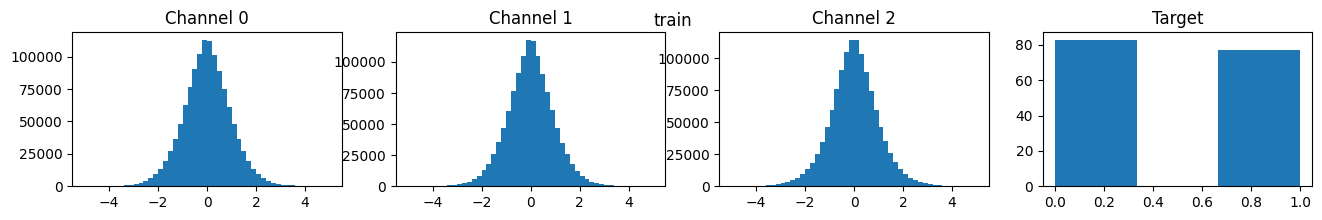

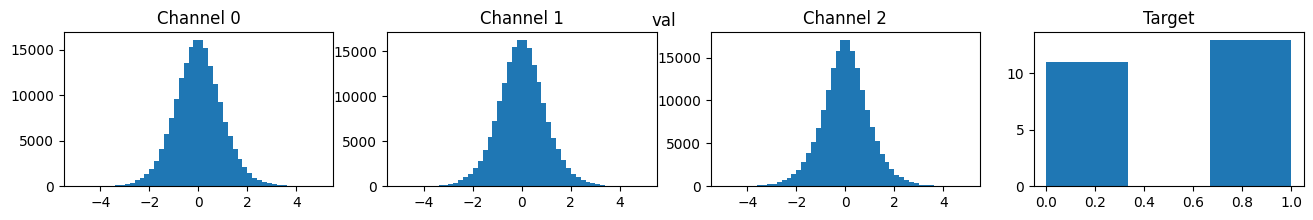

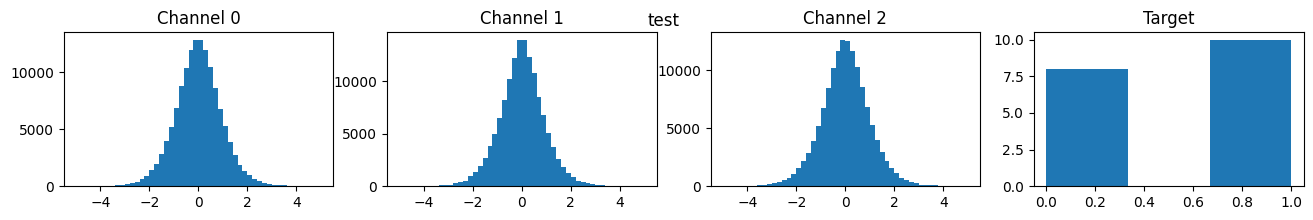

In [10]:
dataset_hists(train_set, val_set, test_set, chunk_bins=50, chunk_range=(-5, 5))
# dataset_hists(train_set, val_set, test_set, chunk_bins=50, chunk_range=(-5, 5), target_bins=10, target_range=(0, 100))